<h1>Linear Regression Multiple Outputs</h1> 


<h2>Objective</h2><ul><li> How to create a complicated models using PyTorch build in functions.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will create a model the PyTorch way. This will help you more complicated models.</p>

<ul>
    <li><a href="#Makeup-Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function the PyTorch way</a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [1]:
# Import the libraries we need for this lab

from torch import nn,optim
import torch
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Set the random seed:


In [2]:
# Set the random seed to 1. 

torch.manual_seed(1)

Use this function for plotting: 


In [17]:
# The function for plotting 2D

def Plot_2D_Plane(model, dataset, n=0, figsize=(10, 8)):
    """
    Plot a 3D visualization of a linear regression model's fit to 2D data
    
    Args:
        model: PyTorch linear model with 2 input features
        dataset: Dataset object with x (n_samples, 2) and y (n_samples, 1)
        n: Iteration/epoch number for title
        figsize: Figure size tuple
    """
    # Extract model parameters
    model.eval()  # Set model to evaluation mode
    
    # Handle different model structures
    if 'linear.weight' in model.state_dict():
        weights = model.state_dict()['linear.weight'].detach().numpy()
        bias = model.state_dict()['linear.bias'].detach().numpy()
    elif 'weight' in model.state_dict():
        weights = model.state_dict()['weight'].detach().numpy()
        bias = model.state_dict()['bias'].detach().numpy()
    else:
        # Try to get first layer parameters
        for key in model.state_dict().keys():
            if 'weight' in key:
                weights = model.state_dict()[key].detach().numpy()
                break
        for key in model.state_dict().keys():
            if 'bias' in key:
                bias = model.state_dict()[key].detach().numpy()
                break
    
    # Ensure we have 2D weights
    if weights.shape[0] == 1 and weights.shape[1] == 2:
        w1, w2 = weights[0]
    elif weights.shape[0] == 2 and weights.shape[1] == 1:
        w1, w2 = weights[:, 0]
    else:
        w1, w2 = weights[0], weights[1] if len(weights) > 1 else 0
    
    b = bias[0] if len(bias) > 0 else 0

    # Prepare data
    if isinstance(dataset.x, torch.Tensor):
        x1 = dataset.x[:, 0].view(-1, 1).detach().numpy()
        x2 = dataset.x[:, 1].view(-1, 1).detach().numpy()
        y = dataset.y.detach().numpy()
    else:
        x1 = dataset.x[:, 0].reshape(-1, 1)
        x2 = dataset.x[:, 1].reshape(-1, 1)
        y = dataset.y.reshape(-1, 1)

    # Create mesh grid for plane
    x1_range = np.linspace(x1.min()-0.5, x1.max()+0.5, 20)
    x2_range = np.linspace(x2.min()-0.5, x2.max()+0.5, 20)
    X, Y = np.meshgrid(x1_range, x2_range)
    Z = w1 * X + w2 * Y + b

    # Create plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot actual data points
    ax.scatter(x1[:, 0], x2[:, 0], y[:, 0], c='red', marker='o', s=50, 
               label='Actual Data', alpha=0.8, depthshade=True)

    # Plot prediction plane with transparency
    surf = ax.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis', 
                          linewidth=0, antialiased=True)

    # Add colorbar for the plane
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Predicted Y')

    # Labels and title
    ax.set_xlabel('X1 Feature', fontsize=12, labelpad=10)
    ax.set_ylabel('X2 Feature', fontsize=12, labelpad=10)
    ax.set_zlabel('Y Target', fontsize=12, labelpad=10)
    ax.set_title(f'Linear Regression Plane - Iteration: {n}', fontsize=14, pad=20)

    # Legend and grid
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
    ax.grid(True, alpha=0.3)

    # Adjust view angle for better visualization
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

    return fig, ax

<!--Empty Space for separating topics-->


<a name="Makeup-Data"><h2 id=" #Makeup-Data" > Make Some Data </h2></a>


Create a dataset class with two-dimensional features:


In [4]:
# Create a 2D dataset

class Data2D(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.zeros(20, 2)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)
        self.x[:, 1] = torch.arange(-1, 1, 0.1)
        self.w = torch.tensor([[1.0], [1.0]])
        self.b = 1
        self.f = torch.mm(self.x, self.w) + self.b    
        self.y = self.f + 0.1 * torch.randn((self.x.shape[0],1))
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):          
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

Create a dataset object:


In [5]:
# Create the dataset object

data_set = Data2D()

<a name="Model_Cost"><h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2></a>


Create a customized linear regression module: 


In [6]:
# Create a customized linear

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Create a model. Use two features: make the input size 2 and the output size 1: 


In [7]:
# Create the linear regression model and print the parameters

model = linear_regression(2,1)
print("The parameters: ", list(model.parameters()))

The parameters:  [Parameter containing:
tensor([[ 0.6209, -0.1178]], requires_grad=True), Parameter containing:
tensor([0.3026], requires_grad=True)]


Create an optimizer  object. Set the learning rate to 0.1. <b>Don't forget to enter the model parameters in the constructor.</b>


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.6.2paramater_hate.png" width="100" alt="How the optimizer works">


In [8]:
# Create the optimizer

optimizer = optim.SGD(model.parameters(), lr=0.1)

Create the criterion function that calculates the total loss or cost:


In [9]:
# Create the cost function
criterion = nn.MSELoss()

Create a data loader object. Set the batch_size equal to 2: 


In [10]:
# Create the data loader

train_loader = DataLoader(dataset=data_set, batch_size=2)

<!--Empty Space for separating topics-->


<a name="BGD"><h2 id="BGD">Train the Model via Mini-Batch Gradient Descent</h2></a>


Run 100 epochs of Mini-Batch Gradient Descent and store the total loss or cost for every iteration. Remember that this is an approximation of the true total loss or cost:


Before Training: 


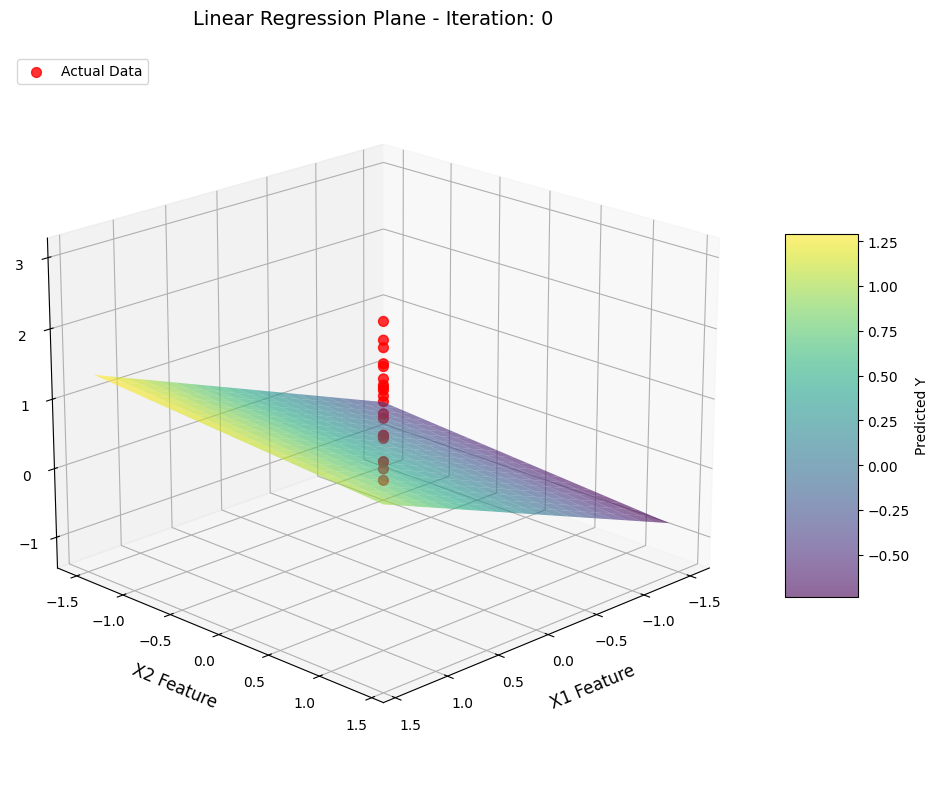

After Training: 


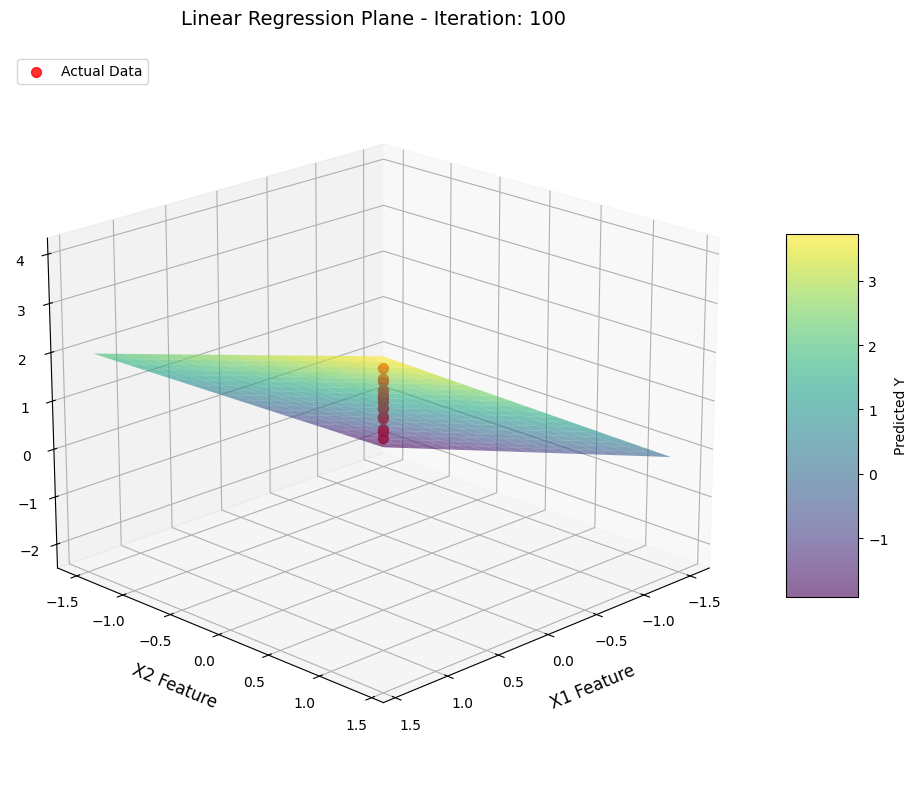

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'Linear Regression Plane - Iteration: 100'}, xlabel='X1 Feature', ylabel='X2 Feature', zlabel='Y Target'>)

In [18]:
# Train the model

LOSS = []
print("Before Training: ")
Plot_2D_Plane(model, data_set)   
epochs = 100
   
def train_model(epochs):    
    for epoch in range(epochs):
        for x,y in train_loader:
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()     
train_model(epochs)
print("After Training: ")
Plot_2D_Plane(model, data_set, epochs)  

Text(0, 0.5, 'Cost/total loss ')

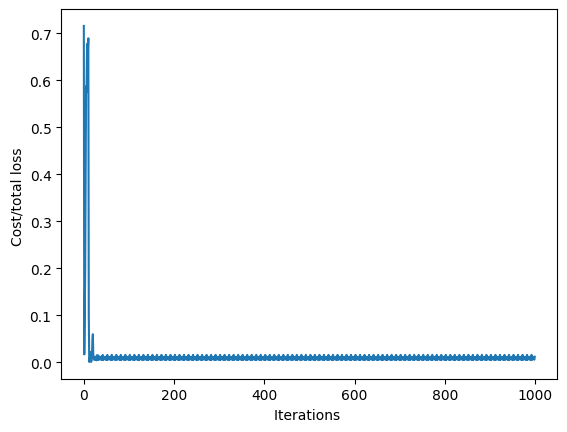

In [19]:
# Plot out the Loss and iteration diagram

plt.plot(LOSS)
plt.xlabel("Iterations ")
plt.ylabel("Cost/total loss ")

<h3>Practice</h3>


Create a new <code>model1</code>. Train the model with a batch size 10 and learning rate 0.1, store the loss or total cost in a list <code>LOSS1</code>, and plot the results.


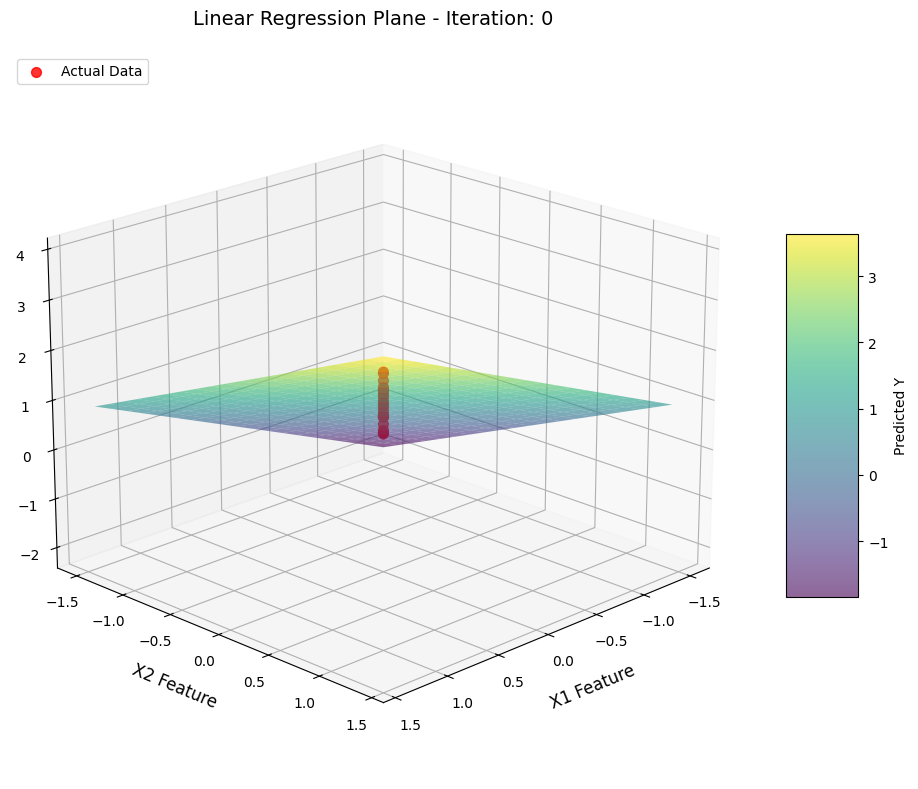

Text(0, 0.5, 'Cost/total loss ')

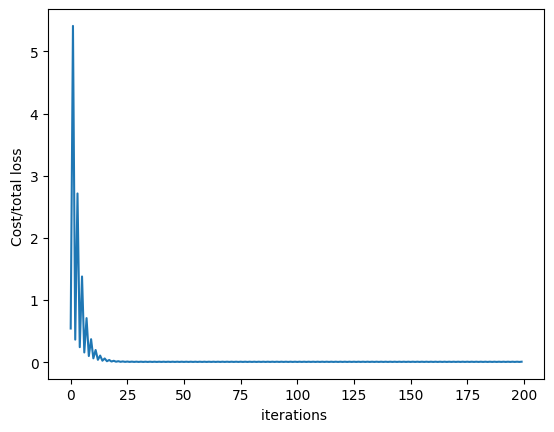

In [28]:
# Practice create model1. Train the model with batch size 10 and learning rate 0.1, store the loss in a list <code>LOSS1</code>. Plot the results.

data_set = Data2D()
LOSS1 = []
train_loader1 = DataLoader(dataset=data_set, batch_size=10)
model1 = linear_regression(2,1)
optimizer1 = optim.SGD(model1.parameters(), lr = 0.1)
epochs = 100
def my_training(epochs):
    for epoch in range(epochs):
        for x,y in train_loader1:
            yhat = model1(x)
            loss = criterion(yhat,y)
            LOSS1.append(loss.item())
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()

my_training(epochs)
Plot_2D_Plane(model1 , data_set)  
plt.plot(LOSS1)
plt.xlabel("iterations ")
plt.ylabel("Cost/total loss ")

Use the following validation data to calculate the total loss or cost for both models:


In [29]:
torch.manual_seed(2)

validation_data = Data2D()
Y = validation_data.y
X = validation_data.x

print("total loss or cost for model: ",criterion(model(X),Y))
print("total loss or cost for model: ",criterion(model1(X),Y))

total loss or cost for model:  tensor(0.0081, grad_fn=<MseLossBackward0>)
total loss or cost for model:  tensor(0.0081, grad_fn=<MseLossBackward0>)


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |
-->


<hr>



## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
